# Initial Design

This notebook contains the code used to select the reaction conditions tested for initial training of the GP. A modified latin hypercube sampling (LHS) strategy is used to select both discrete and continuous variables.  We previously demonstrated that several different designs work well for solvent selection, so LHS was chosen since it is already implemented by GPyOpt.  

## Notes

* **27 June 2019**: There is definitely a problem with the way I'm constructing the initial design currently. I place the principal components on zero-to-one scale for the latin hypercube design. However, the data really follows a normal distribution, so you end up selecting a lot of "extreme" solvents, often the same solvent twice or three times. In fact there is not even a single continuous point, placed in the range where most of the solvents lie in the principal component space. 
<p style="text-align:center;"><img src="outputs/lhs_design_pca_plot_2.svg" width="500"></p>

* **5 July 2019**: Using a smaller range of solvents (80 from the UCB List) helps spread the descriptor space with fewer outliers.  I'm not sure if this is better of worse.

<p style="text-align:center;"><img src="outputs/lhs_design_pca_plot_4.svg" width="500"></p>

## Setup

Let's get everything loaded and ready to go.

In [1]:
#Autoreload automatically reloads any depdencies as you change them
%load_ext autoreload
%autoreload 2

In [2]:
#Import all the necessary packages
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, ContinuousVariable, DiscreteVariable, DescriptorsVariable
from summit.initial_design.latin_designer import LatinDesigner, lhs
from summit.initial_design import RandomDesigner

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

## LHS Design on Full Solvent Library

### Set up Domain

In [3]:
def create_pca_ds(solvent_ds):
    #Reduce solvent descriptors to 3 principal components
    pca = PCA(n_components=3)
    solvent_arr_std = solvent_ds.standardize()
    solvent_arr_pca = pca.fit_transform(solvent_arr_std)

    #Dataset manipulations
    solvent_ds_pcs = DataSet({(f'PC_{i}', 'DATA'): solvent_arr_pca[:, i] for i in range(3)}, 
                             index=solvent_ds.index)
    solvent_ds_pcs.columns.names = ['NAME', 'TYPE']
    order = solvent_ds.columns.codes[0]
    num_columns = len(solvent_ds.columns.levels[0])
    solvent_ds_new = solvent_ds.copy()
    solvent_ds_new.columns = solvent_ds.columns.set_codes(np.array([order.tolist(), [1]*num_columns]))
    solvent_ds_pcs = solvent_ds_pcs.join(solvent_ds_new)
    
    return solvent_ds_pcs

solvent_ds_pcs = create_pca_ds(solvent_ds)

In [4]:
#Specify the optimization space

domain = Domain()

domain += ContinuousVariable(name='temperature',
                             description = "reaction temperature",
                             bounds=[20, 50])

domain += ContinuousVariable(name="acid_conc",
                             description = "propionic acid concentration",
                             bounds=[1,40])

domain += ContinuousVariable(name="cat_load",
                             description = "catalyst loading",
                             bounds=[0.1, 10])

domain += ContinuousVariable(name="co_cat_load",
                             description = "co-catalyst loading",
                             bounds=[15, 1500])

domain += ContinuousVariable(name="acrylate_amine_ratio",
                             description = "molar ratio of acrylate to amine",
                             bounds = [0.8, 2])


domain += ContinuousVariable(name="aldehyde_amine_ratio",
                             description = "molar ratio of aldehyde to amine",
                             bounds=[0.8, 2])

domain += DiscreteVariable(name="co_cat",
                           description="enumeration of the two potential cocatalysts",
                           levels = ['co_cat_1', 'co_cat_2'])


domain += DescriptorsVariable(name="solvent",
                             description="Descriptors of the solvent",
                             ds=solvent_ds_pcs)

domain #The domain should display as an html table 

Name,Type,Description,Values
temperature,"continuous, input",reaction temperature,"[20,50]"
acid_conc,"continuous, input",propionic acid concentration,"[1,40]"
cat_load,"continuous, input",catalyst loading,"[0.1,10]"
co_cat_load,"continuous, input",co-catalyst loading,"[15,1500]"
acrylate_amine_ratio,"continuous, input",molar ratio of acrylate to amine,"[0.8,2]"
aldehyde_amine_ratio,"continuous, input",molar ratio of aldehyde to amine,"[0.8,2]"
co_cat,"discrete, input",enumeration of the two potential cocatalysts,2 levels
solvent,"descriptors, input",Descriptors of the solvent,459 examples of 3 descriptors


### Construct Initial Design

In [5]:
random_seed = 100
rs = np.random.RandomState(random_seed)
ld = LatinDesigner(domain, random_state=rs)
experiments = ld.generate_experiments(20)
experiments_ds = experiments.to_frame()
experiments

,temperature,acid_conc,cat_load,co_cat_load,acrylate_amine_ratio,aldehyde_amine_ratio,co_cat,cas_number
0,41.75,13.675,8.2675,943.125,1.67,1.73,co_cat_2,509-14-8
1,47.75,19.525,6.2875,571.875,1.73,1.43,co_cat_2,100-17-4
2,49.25,11.725,1.3375,349.125,1.43,1.25,co_cat_2,64-17-5
3,35.75,27.325,5.7925,423.375,1.07,1.79,co_cat_1,307-34-6
4,37.25,5.875,1.8325,1165.875,1.01,1.67,co_cat_1,126-33-0
5,43.25,1.975,9.7525,200.625,1.37,1.31,co_cat_1,307-34-6
6,25.25,17.575,0.8425,1388.625,1.19,1.97,co_cat_2,100-63-0
7,44.75,29.275,8.7625,1017.375,0.89,1.85,co_cat_1,132-64-9
8,20.75,3.925,2.8225,274.875,1.79,0.89,co_cat_1,75-25-2
9,29.75,39.025,2.3275,52.125,1.49,1.07,co_cat_2,519-73-3


In [6]:
solvent_ds_pcs.reindex(experiments_ds['cas_number'])[['stenutz_name', 'boiling_point',]]

,stenutz_name,boiling_point
cas_number,,
509-14-8,tetranitromethane,126
100-17-4,4-nitroanisole,259
64-17-5,ethanol,78
307-34-6,perfluoro-n-octane,104
126-33-0,sulfolane,285
307-34-6,perfluoro-n-octane,104
100-63-0,phenylhydrazine,242
132-64-9,dibenzofuran,285
75-25-2,tribromomethane,148


### Analysis

In [7]:
random_seed = 100
rs = np.random.RandomState(random_seed)
n = domain.num_continuous_dimensions()
design = lhs(n, samples=20, criterion='center', random_state=rs)

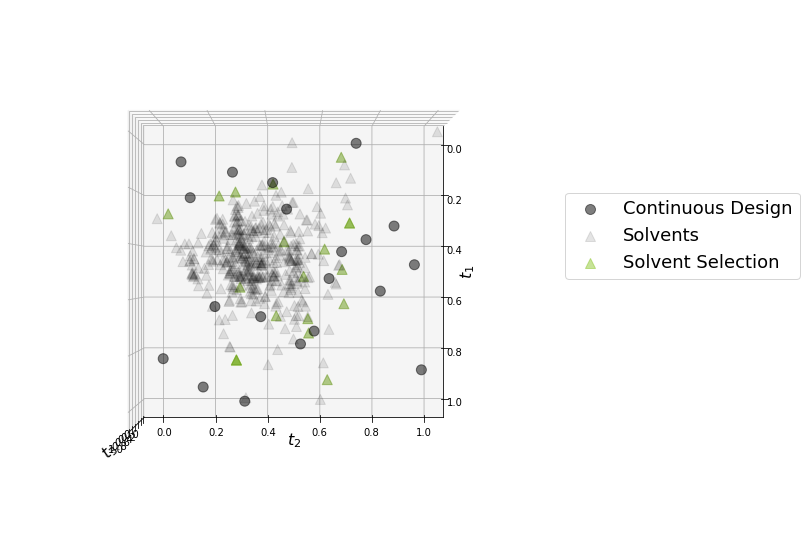

In [65]:
#Plot points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(design[:, 6], design[:, 7], design[:, 8], s=100, label='Continuous Design', color='k', alpha=0.5)
solvent_indices = experiments.get_indices('solvent')
solvent_design_pcs_full = solvent_ds_pcs.zero_to_one()
ax.scatter(solvent_design_pcs_full[:, 0], solvent_design_pcs_full[:, 1], solvent_design_pcs_full[:, 2],
           label='Solvents', s=100, marker = '^', alpha=0.1, color='k')
solvent_design_pcs = solvent_design_pcs_full[solvent_indices[:, 0], :]
ax.scatter(solvent_design_pcs[:, 0], solvent_design_pcs[:, 1], solvent_design_pcs[:, 2],
           label='Solvent Selection', s=100, marker = '^', color='#90c933', alpha=0.5)
fontdict={'fontsize':16}
leg = ax.legend(prop={'size': 18}, loc =(1,0.5))
ax.set_xlabel(r'$t_1$', fontdict=fontdict); ax.set_ylabel(r'$t_2$', fontdict=fontdict); ax.set_zlabel(r'$t_3$', fontdict=fontdict)
ax.view_init(90,0)
plt.savefig('outputs/lhs_design_pca_plot_2.svg', bbox_extra_artists=(leg,),  bbox_inches='tight')

## LHS Design on UCB Filtered Library

### Set up Domain

In [9]:
solvent_ds_ucb = pd.merge(solvent_ds, ucb_ds, left_index=True, right_index=True)
solvent_ds_pcs_ucb  = create_pca_ds(solvent_ds_ucb)

In [10]:
#Specify the optimization space

domain_ucb = Domain()

domain_ucb += ContinuousVariable(name='temperature',
                             description = "reaction temperature",
                             bounds=[20, 50])

domain_ucb += ContinuousVariable(name="acid_conc",
                             description = "propionic acid concentration",
                             bounds=[1,40])

domain_ucb += ContinuousVariable(name="cat_load",
                             description = "catalyst loading",
                             bounds=[0.1, 10])

domain_ucb += ContinuousVariable(name="co_cat_load",
                             description = "co-catalyst loading",
                             bounds=[15, 1500])

domain_ucb += ContinuousVariable(name="acrylate_amine_ratio",
                             description = "molar ratio of acrylate to amine",
                             bounds = [0.8, 2])


domain_ucb += ContinuousVariable(name="aldehyde_amine_ratio",
                             description = "molar ratio of aldehyde to amine",
                             bounds=[0.8, 2])

domain_ucb += DiscreteVariable(name="co_cat",
                           description="enumeration of the two potential cocatalysts",
                           levels = ['co_cat_1', 'co_cat_2'])


domain_ucb += DescriptorsVariable(name="solvent",
                             description="Descriptors of the solvent",
                             ds=solvent_ds_pcs_ucb)

domain_ucb #The domain should display as an html table 

Name,Type,Description,Values
temperature,"continuous, input",reaction temperature,"[20,50]"
acid_conc,"continuous, input",propionic acid concentration,"[1,40]"
cat_load,"continuous, input",catalyst loading,"[0.1,10]"
co_cat_load,"continuous, input",co-catalyst loading,"[15,1500]"
acrylate_amine_ratio,"continuous, input",molar ratio of acrylate to amine,"[0.8,2]"
aldehyde_amine_ratio,"continuous, input",molar ratio of aldehyde to amine,"[0.8,2]"
co_cat,"discrete, input",enumeration of the two potential cocatalysts,2 levels
solvent,"descriptors, input",Descriptors of the solvent,80 examples of 3 descriptors


### Construct Initial Design

In [39]:
random_seed = 100
rs = np.random.RandomState(random_seed)
ld = LatinDesigner(domain_ucb, random_state=rs)
experiments_ucb = ld.generate_experiments(20)
experiments_ds_ucb = experiments_ucb.to_frame()
solvent_names = solvent_ds_pcs_ucb.reindex(experiments_ds_ucb['cas_number'])['stenutz_name'].values
experiments_ds_ucb['solvent'] = solvent_names
experiments_ds_ucb

,temperature,acid_conc,cat_load,co_cat_load,acrylate_amine_ratio,aldehyde_amine_ratio,co_cat,cas_number,solvent
0,41.75,13.675,8.2675,943.125,1.67,1.73,co_cat_2,76-05-1,trifluoroacetic acid
1,47.75,19.525,6.2875,571.875,1.73,1.43,co_cat_2,126-33-0,sulfolane
2,49.25,11.725,1.3375,349.125,1.43,1.25,co_cat_2,121-44-8,triethylamine
3,35.75,27.325,5.7925,423.375,1.07,1.79,co_cat_1,107-21-1,ethanediol
4,37.25,5.875,1.8325,1165.875,1.01,1.67,co_cat_1,7226-23-5,"1,3-dimethyltetrahydropyrimidin-2(1H)-one"
5,43.25,1.975,9.7525,200.625,1.37,1.31,co_cat_1,7732-18-5,water
6,25.25,17.575,0.8425,1388.625,1.19,1.97,co_cat_2,108-75-8,"2,4,6-trimethylpyridine"
7,44.75,29.275,8.7625,1017.375,0.89,1.85,co_cat_1,96-49-1,"1,3-dioxolan-2-one"
8,20.75,3.925,2.8225,274.875,1.79,0.89,co_cat_1,100-51-6,benzyl alcohol
9,29.75,39.025,2.3275,52.125,1.49,1.07,co_cat_2,126-33-0,sulfolane


In [71]:
solvent_ds_pcs_ucb.reindex(experiments_ds_ucb['cas_number'])[['stenutz_name', 'boiling_point']]

,stenutz_name,boiling_point
cas_number,,
76-05-1,trifluoroacetic acid,72
126-33-0,sulfolane,285
121-44-8,triethylamine,90
107-21-1,ethanediol,198
7226-23-5,"1,3-dimethyltetrahydropyrimidin-2(1H)-one",246
7732-18-5,water,100
108-75-8,"2,4,6-trimethylpyridine",171
96-49-1,"1,3-dioxolan-2-one",261
100-51-6,benzyl alcohol,205


### Visualize

In [7]:
random_seed = 100
rs = np.random.RandomState(random_seed)
n = domain.num_continuous_dimensions()
design = lhs(n, samples=20, criterion='center', random_state=rs)

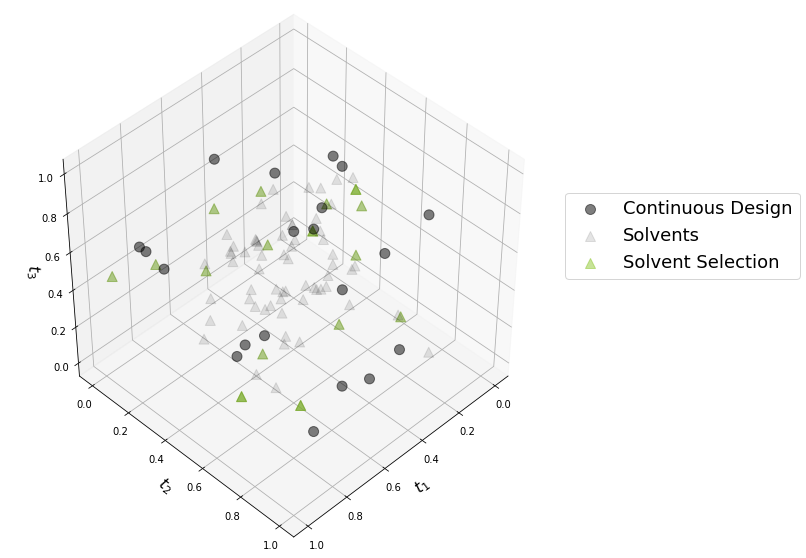

In [70]:
#Plot points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(design[:, 6], design[:, 7], design[:, 8], s=100, label='Continuous Design', color='k', alpha=0.5)
solvent_indices_ucb = experiments_ucb.get_indices('solvent')
solvent_design_pcs_full_ucb = solvent_ds_pcs_ucb.zero_to_one()
ax.scatter(solvent_design_pcs_full_ucb[:, 0], 
           solvent_design_pcs_full_ucb[:, 1], 
           solvent_design_pcs_full_ucb[:, 2],
           label='Solvents', s=100, marker = '^', alpha=0.1, color='k')
solvent_design_pcs_ucb = solvent_design_pcs_full_ucb[solvent_indices_ucb[:, 0], :]
ax.scatter(solvent_design_pcs_ucb[:, 0], 
           solvent_design_pcs_ucb[:, 1],
           solvent_design_pcs_ucb[:, 2],
           label='Solvent Selection', s=100, marker = '^', color='#90c933', alpha=0.5)
fontdict={'fontsize':16}
leg = ax.legend(prop={'size': 18}, loc =(1,0.5))
ax.set_xlabel(r'$t_1$', fontdict=fontdict); ax.set_ylabel(r'$t_2$', fontdict=fontdict); ax.set_zlabel(r'$t_3$', fontdict=fontdict)
ax.view_init(45,45)
plt.savefig('outputs/lhs_design_pca_plot_3.svg', bbox_extra_artists=(leg,),  bbox_inches='tight')